In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

# ===============================
# Carregar os dados
# ===============================

df = pd.read_csv(r'C:/Users/sheil/OneDrive/Área de Trabalho/UFPI2025/topicos_especiais_computacao/mlp/global-data-on-sustainable-energy.csv')

# Remover colunas não numéricas
for col in ['Entity', 'Year']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Substituir vírgulas por pontos
df = df.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)

# Converter colunas para numérico
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# Tratar valores nulos
df.fillna(df.median(numeric_only=True), inplace=True)

# Criar variável de classe
df['Classe_Acesso_Eletricidade'] = np.where(
    df['Access to electricity (% of population)'] > 50, 'Alto', 'Baixo'
)

# Separar X e y
X = df.drop(columns=['Classe_Acesso_Eletricidade', 'Access to electricity (% of population)'])
y = df['Classe_Acesso_Eletricidade']


# ===============================
# Função para rodar os cenários
# ===============================

def avaliar_mlp(X, y, normalizar=True, aplicar_pca=False, n_componentes=0.95,
                 arquitetura=(100, 50, 20), k_folds=5):
    
    # Normalização
    if normalizar:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X)
    else:
        X_proc = X.values  # converter DataFrame para numpy

    # PCA
    if aplicar_pca:
        pca = PCA(n_components=n_componentes)
        X_proc = pca.fit_transform(X_proc)
        n_comp = X_proc.shape[1]
    else:
        n_comp = X_proc.shape[1]

    # Modelo
    mlp = MLPClassifier(hidden_layer_sizes=arquitetura, max_iter=1000, random_state=42)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    acc, prec, rec, f1, auc, kappa = [], [], [], [], [], []

    for train_idx, test_idx in skf.split(X_proc, y):
        X_train, X_test = X_proc[train_idx], X_proc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        y_prob = mlp.predict_proba(X_test)[:,1]  # Prob para classe 'Baixo'

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred, pos_label='Baixo'))
        rec.append(recall_score(y_test, y_pred, pos_label='Baixo'))
        f1.append(f1_score(y_test, y_pred, pos_label='Baixo'))
        auc.append(roc_auc_score((y_test == 'Baixo').astype(int), y_prob))
        kappa.append(cohen_kappa_score(y_test, y_pred))

    resultado = {
        'Normalizado': normalizar,
        'PCA': aplicar_pca,
        'K-fold': k_folds,
        'Arquitetura': str(arquitetura),
        'Acuracia': np.mean(acc),
        'Precisao': np.mean(prec),
        'Recall': np.mean(rec),
        'F1-Score': np.mean(f1),
        'AUC': np.mean(auc),
        'Kappa': np.mean(kappa),
        'N-Componentes': n_comp
    }
    return resultado


# ===============================
# Executando TODOS os cenários
# ===============================

resultados = []

# Parâmetros para varrer
normalizacao = [True]
usar_pca = [False, True]
arquiteturas = [(8,4), (32,16,8)]
kfolds = [5, 50]

for norm in normalizacao:
    for pca in usar_pca:
        for arch in arquiteturas:
            for k in kfolds:
                print(f"Rodando: Norm={norm} | PCA={pca} | Arch={arch} | K={k}")
                res = avaliar_mlp(X, y,
                                  normalizar=norm,
                                  aplicar_pca=pca,
                                  arquitetura=arch,
                                  k_folds=k)
                resultados.append(res)


# ===============================
# Resultados consolidados
# ===============================

df_resultados = pd.DataFrame(resultados)

# Mostrar tabela ordenada por Acurácia decrescente
print("\nResultados Consolidados:\n")
print(df_resultados.sort_values(by='Acuracia', ascending=False).round(4))


# ===============================
# Exportar resultados se quiser
# ===============================

# df_resultados.to_csv('resultados_mlp.csv', index=False)


Rodando: Norm=True | PCA=False | Arch=(8, 4) | K=5
Rodando: Norm=True | PCA=False | Arch=(8, 4) | K=50
Rodando: Norm=True | PCA=False | Arch=(32, 16, 8) | K=5
Rodando: Norm=True | PCA=False | Arch=(32, 16, 8) | K=50
Rodando: Norm=True | PCA=True | Arch=(8, 4) | K=5
Rodando: Norm=True | PCA=True | Arch=(8, 4) | K=50
Rodando: Norm=True | PCA=True | Arch=(32, 16, 8) | K=5
Rodando: Norm=True | PCA=True | Arch=(32, 16, 8) | K=50

Resultados Consolidados:

   Normalizado    PCA  K-fold  Arquitetura  Acuracia  Precisao  Recall  \
3         True  False      50  (32, 16, 8)    0.9734    0.9333  0.9449   
6         True   True       5  (32, 16, 8)    0.9726    0.9283  0.9425   
2         True  False       5  (32, 16, 8)    0.9710    0.9266  0.9359   
7         True   True      50  (32, 16, 8)    0.9704    0.9280  0.9357   
1         True  False      50       (8, 4)    0.9649    0.9058  0.9358   
5         True   True      50       (8, 4)    0.9633    0.8997  0.9360   
4         True   True      

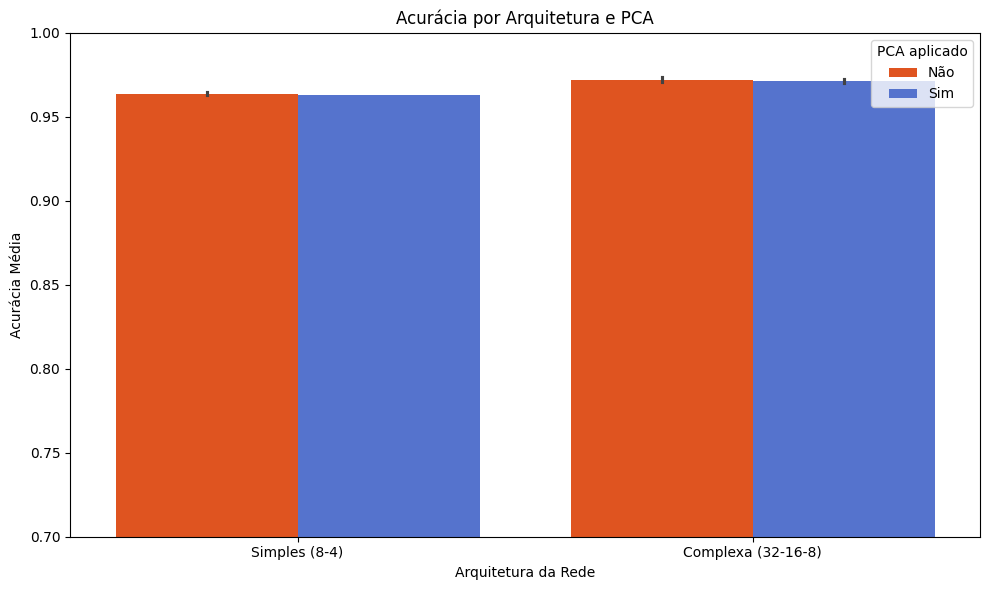

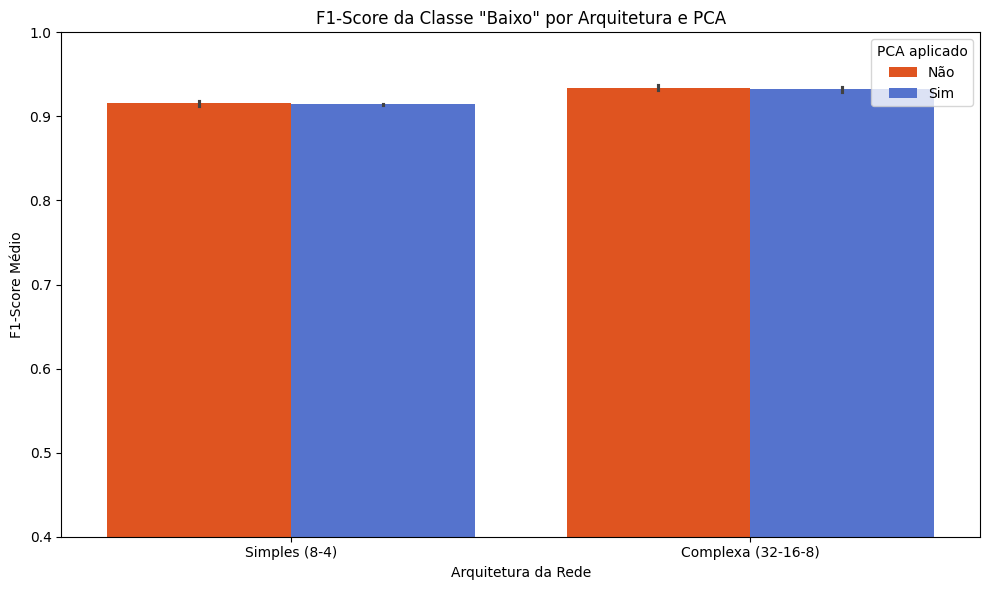

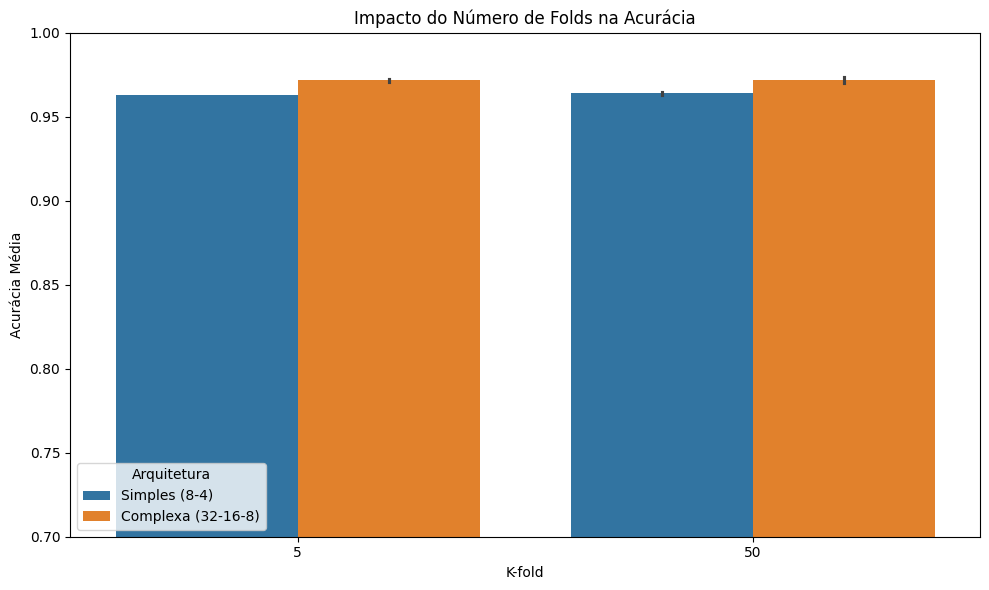

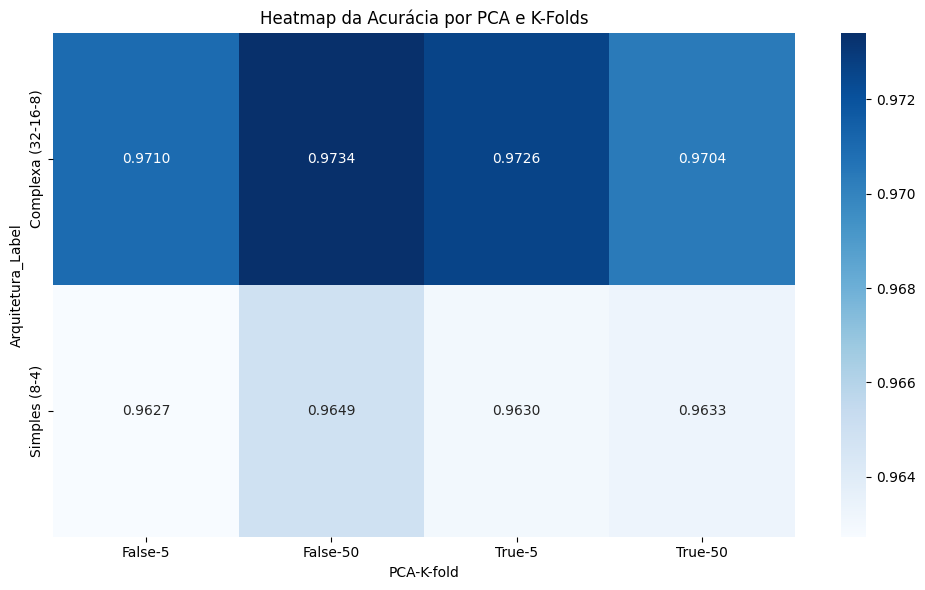

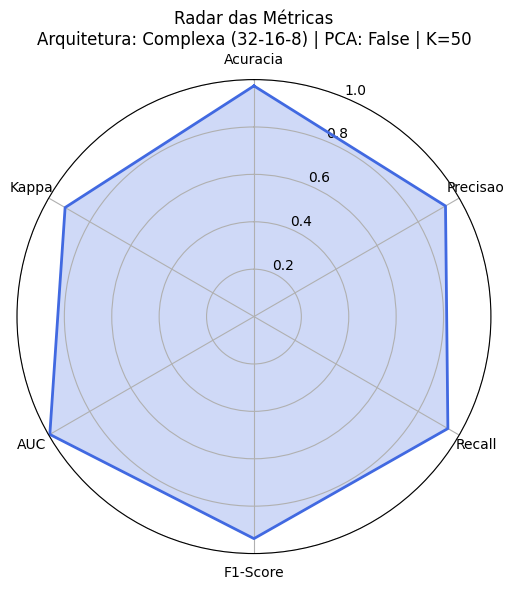

In [9]:
import matplotlib.pyplot as plt  
import seaborn as sns
import numpy as np
from math import pi


# ===============================
# AJUSTAR LABELS DAS ARQUITETURAS
# ===============================

df_resultados['Arquitetura_Label'] = df_resultados['Arquitetura'].map({
    '(8, 4)': 'Simples (8-4)',
    '(32, 16, 8)': 'Complexa (32-16-8)'
})


# ===============================
# DEFINIR PALETA DE CORES
# ===============================
cores_personalizadas = {True: 'royalblue', False: 'orangered'}


# ===============================
# GRÁFICO 1: Acurácia por Arquitetura e PCA
# ===============================

plt.figure(figsize=(10,6))
grafico = sns.barplot(data=df_resultados, x='Arquitetura_Label', y='Acuracia', hue='PCA', palette=cores_personalizadas)
plt.title('Acurácia por Arquitetura e PCA')
plt.ylabel('Acurácia Média')
plt.xlabel('Arquitetura da Rede')
plt.ylim(0.7, 1)

# Corrigir legenda mantendo as cores
handles, labels = grafico.get_legend_handles_labels()
labels = ['Não', 'Sim']
plt.legend(handles=handles, labels=labels, title='PCA aplicado')

plt.tight_layout()
plt.show()



# ===============================
# GRÁFICO 2: F1-Score da Classe "Baixo"
# ===============================
plt.figure(figsize=(10,6))
grafico = sns.barplot(data=df_resultados, x='Arquitetura_Label', y='F1-Score', hue='PCA', palette=cores_personalizadas)
plt.title('F1-Score da Classe "Baixo" por Arquitetura e PCA')
plt.ylabel('F1-Score Médio')
plt.xlabel('Arquitetura da Rede')
plt.ylim(0.4, 1)

handles, labels = grafico.get_legend_handles_labels()
labels = ['Não', 'Sim']
plt.legend(handles=handles, labels=labels, title='PCA aplicado')

plt.tight_layout()
plt.show()


# ===============================
# GRÁFICO 3: Comparação por Número de Folds
# ===============================
plt.figure(figsize=(10,6))
sns.barplot(data=df_resultados, x='K-fold', y='Acuracia', hue='Arquitetura_Label')
plt.title('Impacto do Número de Folds na Acurácia')
plt.ylabel('Acurácia Média')
plt.xlabel('K-fold')
plt.ylim(0.7, 1)
plt.legend(title='Arquitetura')
plt.tight_layout()
plt.show()


# ===============================
# GRÁFICO 4: Heatmap das Métricas
# ===============================
plt.figure(figsize=(10,6))
pivot = df_resultados.pivot_table(
    values='Acuracia',
    index='Arquitetura_Label',
    columns=['PCA', 'K-fold']
)
sns.heatmap(pivot, annot=True, fmt=".4f", cmap='Blues')
plt.title('Heatmap da Acurácia por PCA e K-Folds')
plt.tight_layout()
plt.show()


# ===============================
# GRÁFICO 5: Radar Comparativo das Métricas
# ===============================

# Selecionar o melhor cenário
escenario = df_resultados.iloc[df_resultados['Acuracia'].idxmax()]

labels = ['Acuracia', 'Precisao', 'Recall', 'F1-Score', 'AUC', 'Kappa']
stats = [
    escenario['Acuracia'],
    escenario['Precisao'],
    escenario['Recall'],
    escenario['F1-Score'],
    escenario['AUC'],
    escenario['Kappa']
]

# Preparar dados
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats += stats[:1]
angles += angles[:1]

# Plotar
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

ax.plot(angles, stats, color='royalblue', linewidth=2)
ax.fill(angles, stats, color='royalblue', alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)

ax.set_title(
    f"Radar das Métricas\nArquitetura: {escenario['Arquitetura_Label']} | PCA: {escenario['PCA']} | K={escenario['K-fold']}",
    size=12
)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()
